In [1]:
# import eda libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'], 
                    parse_dates=['date'], 
                    date_format="%d.%m.%Y")
sales = sales.sort_values(by='date')

# First, let's analyze how all the shops performed in terms of total items sold over the years.

In [6]:
all_shops_items_sum = sales.groupby('date').sum()[['item_cnt_day']]
all_shops_items_mean = sales.groupby('date').mean()[['item_cnt_day']]

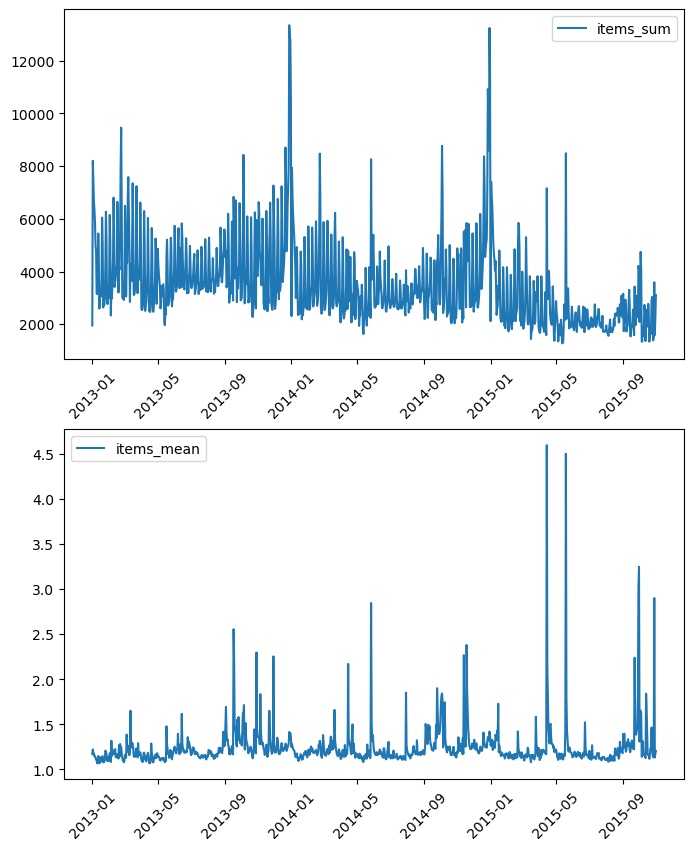

In [47]:
fig, ax = plt.subplots(2,1, figsize=(8,10))
ax[0].plot('item_cnt_day', data=all_shops_items_sum, label='items_sum')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend()
ax[1].plot('item_cnt_day', data=all_shops_items_mean, label='items_mean')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend()
plt.show()

###### It appears that the total number of items sold in the shops is decreasing over the years whereas the mean of items sold over the years is fluctuating

# Let's now see how the individual shops performed over the years.

In [73]:
individual_shops_items_sum = sales.groupby(['shop_id', 'date']).sum()[['item_cnt_day']]
individual_shops_items_sum = individual_shops_items_sum.reset_index()
individual_shops_items_mean = sales.groupby(['shop_id', 'date']).mean()[['item_cnt_day']]
individual_shops_items_mean = individual_shops_items_mean.reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(8,10))
sns.boxplot(x='date', y='item_cnt_day', hue='shop_id', data=individual_shops_items_sum)
plt.show()